# Generativity and Adversarial Gradients

**Purpose:** Quick check to assert that the adversiarial gradients point to the same object (and not just a copy of weights). 

note: git commit `f241a9c` , if there is an error and it is fixed, this notebook will not run appropriately

**Result:** Matrices do not refer to the same object. I believe the transpose operation is copying a new object. 

# Imports

In [1]:
from typing import List

import copy

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

In [2]:
# In case you are fortunate enough to have access to a GPU...
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"using {device = }")

using device = 'cuda'


# Data: MNIST

In [95]:
# You can change img_size to 14 if you want to use smaller (14x14) images.
img_size = 28
ds_full = torchvision.datasets.MNIST('./files/', train=True, download=True,
                                transform=T.Compose([
                                T.Resize((img_size,img_size)),
                                T.ToTensor(),
                                T.Lambda((lambda x: torch.flatten(x))),
                            ]))

In [96]:
# You can change img_size to 14 if you want to use smaller (14x14) images.
img_size = 28
ds_test = torchvision.datasets.MNIST('./files/', train=False, download=True,
                                transform=T.Compose([
                                T.Resize((img_size,img_size)),
                                T.ToTensor(),
                                T.Lambda((lambda x: torch.flatten(x))),
                            ]))

In [101]:
#ds = ds_full
n = 1024*2
n_samples = n if n <= len(ds_full) else len(ds_full)

ds = torch.utils.data.Subset(ds_full, range(n_samples))
dl = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=True)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=256)

# Network

In [92]:
class MyNet(nn.Module):
    '''
     net = MyNet(img_size=28)
     
     Creates a neural network to do classification on MNIST.
     It assumes the images will be (img_size)x(img_size).
     
     It projects to a latent space.
     From that latent space, it:
      1) projects to an output classification layer (log softmax), and
      2) projects back down through the network to a reconstruction of the input.
     
    '''
    def __init__(self, img_size=28, latent_dim=5):
        super().__init__()
        
        # Discriminative network
        self.D = nn.ModuleList()
        
        # Input -> Hidden 1
        self.D.append(nn.Linear(img_size**2, 100))
        self.D.append(nn.ReLU())
        
        # Hidden 1 -> Hidden 2
        self.D.append(nn.Linear(100, latent_dim))
        self.D.append(nn.ReLU())
        
        # Classifier
        self.classifier = nn.Sequential(
                            nn.Linear(latent_dim, 10),
                            nn.LogSoftmax(dim=-1),
                            )

        # The generative network
        self.G = nn.ModuleList()
        
        # Hidden 2 -> Hidden 1
        self.G.append(nn.Linear(latent_dim, 100))
        self.G.append(nn.ReLU())
        
        # Hidden 1 -> Input
        self.G.append(nn.Linear(100, img_size**2))
        self.G.append(nn.Sigmoid())
        
        # Tie the weights of D and G
        #TODO check if pointer or copy
        self.G[-2].weight.data = self.D[0].weight.data.transpose(1,0)
        self.G[-4].weight.data = self.D[2].weight.data.transpose(1,0)
        self.G[-4].bias.data = self.D[0].bias.data
        
        self.classifier_loss = nn.NLLLoss()
        self.recon_loss = nn.BCELoss()
        self.losses = []
        self.to(device)
        
        # checkpoint states
        self.optimizer = None
        
        
    def forward(self, x):
        '''Latent -> Classification'''
        return self.classifier(self.discriminate(x))

    
    def ae(self,x):
        return self.generate(self.discriminate(x))

    
    def discriminate(self, x):
        '''Input -> Latent'''
        for d in self.D:
            x = d(x)
        return x


    def generate(self, z):
        '''
         Latent -> Input
         x_had = net.generate(z)
         
         Runs the network in reverse, generating a batch of inputs from
         a batch of latent vectors.
         
         Inputs:
          z      (D,latent_dim) tensor of latent vectors
          
         Outputs:
          x_hat  (D,784) tensor containing the batch of inputs
        '''
        for g in self.G:
            z = g(z)
        return z
    
      
    def learn(self, 
              dl, 
              optimizer=None, 
              epochs=10, 
              beta=0.,
              checkpoints=[],
              path: str=None):
        '''
         net.learn(dl, optimizer=None, epochs=10, beta=0.)
         
         Train the network on the dataset represented by the DataLoader dl.
         The default optimizer is Adam().
         
         The targets for the dataset are assumed to be class indices.
         
         beta is the weight for the reconstruction loss.
         
         Args:
         
             checkpoints (Boolean|List[int]): if True, save every 10-epochs. if List[int], save each listed epoch.
             path (str): optional path to save model checkpoints.
        '''
        if optimizer is None:
            print('Need to specify an optimizer')
            return
        else:
            self.optimizer = optimizer
        
        for epoch in tqdm(range(epochs)):
            total_loss = 0.
            count = 0.
            for x, t in dl:
                x = x.to(device)   # for use with a GPU
                t = t.to(device)
                z = self.discriminate(x)
                y = self.classifier(z)
                xhat = self.generate(z)
                loss = self.classifier_loss(y, t) + beta*self.recon_loss(xhat, x)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()*len(t)
                count += 1.
            self.losses.append(total_loss/len(dl.dataset))
            #print(f'Epoch: {epoch}, loss: {total_loss/count}')
            if checkpoints:
                self.checkpoint(epoch, checkpoints, path)
                
        plt.figure(figsize=(4,4))
        plt.plot(self.losses); plt.yscale('log');


    def checkpoint(self, 
                   epoch: int, 
                   checkpoints: List[int]=[],
                   path: str="model-checkpoints.pt"):
        """ Save model checkpoints. 
        
            Args:
                epoch (int): Current training epoch.
                checkpoints (List[int]): list of epochs to save model at. if True, save every 10.model 
                path (str): path to save model.pt
                
        """
        
        def save_checkpoint(self, epoch, path):
            path = path.split(".pt")[0] + f"-{epoch}" + ".pt"
            torch.save({'epoch': epoch,
                        'model_state_dict': self.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'loss': self.losses[-1],
                        }, 
                        path) 
        
        if checkpoints is True:
            if epoch % 10 == 0: 
                save_checkpoint(self, epoch, path)
        elif epoch in checkpoints:
            save_checkpoint(self, epoch, path)     

# Assert Objects

In [93]:
net = MyNet(8*8, latent_dim=8)#.to(device)

In [59]:
assert net.G[-2].weight.data is net.D[0].weight.data
assert net.G[-4].weight.data is net.D[2].weight.data
assert net.G[-4].bias.data is net.D[0].bias.data

AssertionError: 

In [60]:
assert net.G[-2].weight.data is net.D[0].weight.data.T
assert net.G[-4].weight is net.D[2].weight
assert net.G[-4].bias is net.D[0].bias

AssertionError: 

Looks like these asserts will fail, not because the pointers aren't to the same object, but because the transpose operation breaks the `is` comparison. 

So, have to just test if updates to one affect the other

In [73]:
#TODO check if pointer or copy
#self.G[-2].weight.data = self.D[0].weight.data.transpose(1,0)

In [77]:
net.G[-2].weight.data[0:1,] = 1

assert net.G[-2].weight.data is net.D[0].weight.data

AssertionError: 

In [78]:
net.G[-2].weight.data[0:1,]

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], device='cuda:0')

In [87]:
net.D[0].weight.data[:,0]

tensor([ 0.0133, -0.0125,  0.0047, -0.0097,  0.0132,  0.0130,  0.0105, -0.0084,
         0.0037, -0.0114,  0.0008, -0.0023,  0.0139, -0.0043, -0.0039,  0.0100,
        -0.0152, -0.0136, -0.0003, -0.0043, -0.0051, -0.0006,  0.0102, -0.0050,
         0.0110, -0.0043, -0.0083, -0.0109,  0.0017,  0.0114,  0.0146, -0.0126,
        -0.0108,  0.0077, -0.0142,  0.0042,  0.0122, -0.0142,  0.0009,  0.0111,
         0.0054, -0.0150,  0.0089,  0.0064, -0.0077, -0.0106, -0.0036, -0.0107,
        -0.0134,  0.0117, -0.0123,  0.0149,  0.0074, -0.0092, -0.0153, -0.0041,
        -0.0054,  0.0149, -0.0154, -0.0085, -0.0019,  0.0110, -0.0107,  0.0119,
        -0.0139, -0.0012,  0.0006, -0.0119,  0.0068, -0.0064,  0.0088, -0.0004,
        -0.0117, -0.0039, -0.0091,  0.0115,  0.0101,  0.0005,  0.0014, -0.0112,
        -0.0088,  0.0027,  0.0019,  0.0111, -0.0138, -0.0031,  0.0107,  0.0038,
         0.0042, -0.0010,  0.0101,  0.0138, -0.0152, -0.0091,  0.0131, -0.0086,
         0.0029, -0.0091, -0.0125, -0.00

# Train Net and Assert Weights

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.03it/s]


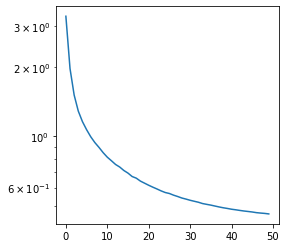

In [104]:
img_size = 28
net = MyNet(img_size, latent_dim=8)#.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
checkpoints = False
#path = f"data/mnist-{len(dl)}-checkpoint.pt"

net.learn(dl, 
          optimizer=optimizer, 
          epochs=50, 
          beta=3., 
          checkpoints=checkpoints)

In [145]:
g = [-2,-4]
d = [0, 2]

for i,j in zip(g,d):
    print(f"for {i=}, {j=}")
    assert torch.equal(net.G[i].weight.data, net.D[j].weight.data.T)

for i=-2, j=0


AssertionError: 

In [146]:
net.G[-2].weight.data[:5,:5]

tensor([[-0.0421, -0.1027, -0.0887, -0.0810, -0.1047],
        [-0.0423, -0.1020, -0.0631, -0.1103, -0.0797],
        [-0.0731, -0.0900, -0.0612, -0.0843, -0.1029],
        [-0.0583, -0.1042, -0.1048, -0.0953, -0.0914],
        [-0.0605, -0.0500, -0.0737, -0.1257, -0.0463]], device='cuda:0')

In [147]:
net.D[0].weight.data[:5,:5]

tensor([[ 0.0315,  0.0320,  0.0012,  0.0150,  0.0161],
        [-0.0310, -0.0298, -0.0176, -0.0327,  0.0244],
        [-0.0173,  0.0089,  0.0108, -0.0336,  0.0005],
        [ 0.0079, -0.0209,  0.0042, -0.0095, -0.0317],
        [-0.0327, -0.0071, -0.0303, -0.0197,  0.0285]], device='cuda:0')

note: ID is of the pointer, not the object, it seems.

In [129]:
id(net.G[-2].weight.data)

2218482434368

In [130]:
id(net.D[0].weight.data)

2218482622848

In [131]:
net.G[-2].weight.data[0:1,].shape

torch.Size([1, 100])

In [132]:
net.D[0].weight.data[:,0:1].T.shape

torch.Size([1, 100])

In [133]:
net.G[-2].weight.data[0:1,]

tensor([[-0.0421, -0.1027, -0.0887, -0.0810, -0.1047, -0.0447, -0.0380, -0.0899,
         -0.7438, -0.0936, -0.0940, -0.0934, -0.3122, -0.0849, -0.0620, -0.0655,
         -0.1028, -0.0527, -0.0633, -0.0934, -0.0674, -0.0363, -0.0759, -0.0484,
         -0.0934, -0.0781, -0.0563, -0.0569, -0.0354, -0.0805, -0.1186, -0.0926,
         -0.0558, -0.0648, -0.0511, -0.0938, -0.0799, -0.0925, -0.0421, -0.0501,
         -0.0855, -0.3286, -0.0948, -0.0963, -0.0506, -0.0907, -0.0520, -0.0568,
         -0.0710, -0.0980, -0.4106, -0.0503, -0.0804, -0.1271, -0.0857, -0.0699,
         -0.0740, -0.1021, -0.0987, -0.0509, -0.0634, -0.0939, -0.1103, -0.1668,
         -0.0822, -0.0908, -0.0537, -0.3880, -0.0813, -0.0883, -0.1079, -0.0494,
         -0.1145, -0.1281, -0.0737, -0.0662, -0.6201, -0.0688, -0.0391, -0.1074,
         -0.1131, -0.0830, -0.0964, -0.1020, -0.1239, -0.1141, -0.0836, -0.0765,
         -0.1162, -0.7582,  0.0107, -0.0728, -0.3588, -0.0708, -0.0894, -0.0436,
         -0.0946, -0.0394, -

In [134]:
net.D[0].weight.data[:,0:1]

tensor([[ 3.1472e-02],
        [-3.1008e-02],
        [-1.7325e-02],
        [ 7.9185e-03],
        [-3.2723e-02],
        [ 2.6506e-02],
        [ 3.1762e-02],
        [ 1.0523e-02],
        [ 1.7864e-02],
        [-2.0025e-02],
        [ 7.1609e-03],
        [-2.0909e-02],
        [-3.3396e-02],
        [-1.2313e-02],
        [ 2.7375e-02],
        [ 5.5752e-03],
        [-4.3411e-04],
        [ 3.3317e-02],
        [ 8.9496e-03],
        [-2.4617e-02],
        [ 1.3629e-02],
        [ 3.0907e-02],
        [-4.7325e-03],
        [ 2.1628e-02],
        [-1.8191e-02],
        [-5.3357e-03],
        [ 2.2850e-02],
        [ 1.0913e-02],
        [ 3.5144e-02],
        [ 4.3305e-03],
        [-1.6372e-02],
        [-6.2503e-05],
        [ 1.4757e-02],
        [ 4.0690e-03],
        [ 2.6188e-02],
        [-2.4690e-02],
        [-7.1720e-03],
        [-2.1473e-02],
        [ 3.0564e-02],
        [ 2.3339e-02],
        [-1.0586e-02],
        [ 1.0492e-03],
        [-2.0740e-02],
        [-2

In [62]:
net.G[-2].weight.data

tensor([[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
          1.0000e+00,  1.0000e+00],
        [-1.1134e-02, -3.7724e-03,  1.3088e-02,  ..., -1.1755e-03,
          1.1159e-02,  5.9929e-03],
        [-1.5273e-03, -1.1293e-02,  4.1296e-03,  ..., -3.3248e-04,
          9.1769e-03, -3.3658e-03],
        ...,
        [-1.1329e-03,  4.8545e-03, -1.1407e-02,  ...,  9.5538e-03,
          1.2967e-02,  4.3756e-03],
        [ 5.9405e-03, -1.1547e-02, -2.3336e-03,  ...,  1.0199e-02,
         -7.5089e-03,  9.7291e-03],
        [ 8.3723e-04,  1.0922e-02, -1.4422e-02,  ...,  6.2752e-03,
         -7.0702e-03, -1.3311e-02]], device='cuda:0')

# Check on Arbitrary Tensors

In [153]:
a = torch.rand((2,4))
b = a.T

In [154]:
print(id(a))
print(id(b))

2218482528576
2219445406336


In [155]:
a

tensor([[0.4323, 0.3299, 0.1833, 0.1652],
        [0.9400, 0.8169, 0.2842, 0.6576]])

In [172]:
a[0,:] = 9
b
assert torch.equal(b[:,0], torch.tensor([9.]*4))

In [168]:
 torch.tensor([9]*4)

tensor([9, 9, 9, 9])

In [162]:
b[:,0]

tensor([9., 9., 9., 9.])

In [144]:
torch.equal(a, b.T)

True

In [37]:
net.D[0].weight.data.T

tensor([[-0.0135,  0.0116, -0.0149,  ...,  0.0043,  0.0126, -0.0035],
        [-0.0032,  0.0068,  0.0087,  ..., -0.0041, -0.0006, -0.0070],
        [ 0.0023,  0.0073, -0.0083,  ..., -0.0140,  0.0017, -0.0065],
        ...,
        [ 0.0139, -0.0082,  0.0112,  ..., -0.0114, -0.0045, -0.0019],
        [ 0.0066,  0.0042, -0.0047,  ...,  0.0103,  0.0091, -0.0073],
        [-0.0150,  0.0064,  0.0040,  ...,  0.0056,  0.0083,  0.0140]],
       device='cuda:0')

In [31]:
assert net.G[-2] is net.D[0]
assert net.G[-4] is net.D[2]
assert net.G[-4] is net.D[0]

AssertionError: 

In [32]:
net.G[-2]

Linear(in_features=100, out_features=4096, bias=True)

In [33]:
net.D[0]

Linear(in_features=4096, out_features=100, bias=True)